# Binomial_Pricing_Model

Let S denote the price of the stock today, and let T denote the time until expiry of the option, in years. We'll divide this period into N equal time intervals, of length ΔT=T/N Assume that in each time period, the stock price changes by either multiplying by u, which we consider as an up movement, or by d, the down movement. We need to assume d<erΔT<u, where r is the risk-free interest rate, to avoid the possibility of arbitrage. If k time periods have passed, m is number if up movement : S(k,m)=S * u ** m * d ** (k-m)

C(N,m)=max(S(N,m)−K,0)

Once we know the value of the option at the end of the tree, we can work backward as before to figure out the value of the option at every node. Let C(k,m) denote the value of the option at the node that is k steps into the tree with m up movements in the stock price. The two following nodes in the tree are C(k+1,m+1) (if the price moves up) and C(k+1,m) (if the price moves down). If we let p denote the risk-neutral probability

p = (e**(rΔT)−d)/(u−d)

of a movement up, then the expected value of the option in the next step is
pC(k+1,m+1)+(1−p)C(k+1,m)

and so the value of the option at C(k,m) is the above expected value, discounted to today using the risk-free interest rate. That is

C(k,m)=e−rΔT(pC(k+1,m+1)+(1−p)C(k+1,m))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

def first_binomial_call(S, K, T, r, u, d, N):
    dt = T/N
    p = ((math.exp(r*dt) - d)/(u-d))
    C = {}
    for m in range(0, N+1):
            C[(N, m)] = max((S*u**m*d**(N-m)) - K, 0)
    for k in range(N-1, -1, -1):
        for m in range(0,k+1):
            C[(k, m)] = math.exp(-r*dt)*(p*C[(k+1,m+1)] + (1-p)*C[(k+1,m)])
    return C[(0,0)]

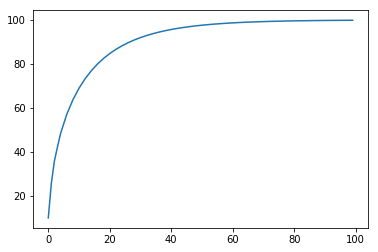

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
call = []
for N in range(1,1000,10):
    call_price = first_binomial_call(100, 100, 1, 0, 1.2, 0.8, N) 
    # print(call_price)
    call.append(call_price)
call = pd.DataFrame(call)
plt.plot(call)

In [3]:
#What can be the Max possible value of the Call_Option as we increase N?
#Ans: 100

# Black_Scholes_Model


In [4]:
# c = S*N(d1) − K*e**−(rT)*N(d2)
# p = K*e**(−rT)*N(−d2) − S*N(−d1)

# d1 = (ln(S/K)+(r+(σ**2)/2)*T)/sigma*T**0.5
# d2 =  d1−sigma*T**0.5


In [5]:
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [6]:
def euro_vanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S/K) + (r + (sigma**2)/2)*T)/(sigma*T**0.5)
    d2 = d1 - sigma*T**0.5
    
    if option == 'call':
        result = S * si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    if option == 'put':
        result = K*np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

In [7]:
 euro_vanilla(S = 80, K=100, T=1, r=0.02/252, sigma=.25, option = 'call')   

2.266816097057781

In [8]:
# Fetching nifty_data

nifty_data = pd.read_csv('Option_Data.csv')

nifty_data.head()


,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value,Time to Expiry
0,NIFTY,10-11-2017,28-Dec-17,CE,10100.0,342.00,384.55,319.95,346.65,357.25,346.65,369.0,2891.94,96.77,270000.0,6000.0,10321.75,48.0
1,NIFTY,10-11-2017,28-Dec-17,CE,10200.0,274.05,308.15,246.00,280.10,288.00,280.10,814.0,6395.29,168.19,463125.0,1200.0,10321.75,48.0
2,NIFTY,10-11-2017,28-Dec-17,CE,10300.0,213.15,239.05,184.95,214.45,220.00,214.45,2489.0,19614.17,386.64,583650.0,7725.0,10321.75,48.0
3,NIFTY,10-11-2017,28-Dec-17,CE,10400.0,156.10,177.75,133.40,153.65,161.45,153.65,2648.0,20963.42,309.02,436650.0,3675.0,10321.75,48.0
4,NIFTY,10-11-2017,28-Dec-17,CE,10500.0,117.45,128.45,92.60,112.20,117.70,112.20,8500.0,67640.94,703.44,1862175.0,2625.0,10321.75,48.0


In [9]:
# Pick a Strike of your choice. Calculate required inputs for pricing the call and put option of that strike for all the dates

Strike_Price = 10500.0
new_data = nifty_data[nifty_data['Strike Price'] == Strike_Price]
new_data['volatility'] =  np.std(new_data['Underlying Value'].pct_change())

new_data['Theoritical_Call'] = 0
new_data['Theoritical_Put'] = 0

new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data.index  = new_data['Date'] 

for i in range(len(new_data)):
    new_data['Theoritical_Call'][i] = euro_vanilla(S = new_data['Underlying Value'][i], K = new_data['Strike Price'][i], T = new_data['Time to Expiry'][i] , r = 0.02/252,sigma= new_data['volatility'][i] , option = 'call')
    new_data['Theoritical_Put'][i] = euro_vanilla(S = new_data['Underlying Value'][i], K = new_data['Strike Price'][i], T = new_data['Time to Expiry'][i] , r = 0.02/252 , sigma= new_data['volatility'][i], option = 'put')
  
    
  

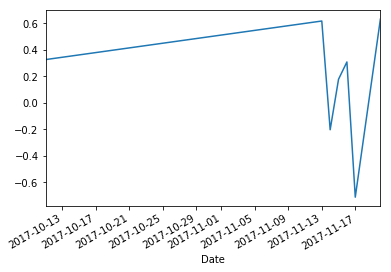

In [10]:
# Implement the put_call_parity by taking all the values on one side and calculate the net sum. Plot the sum to check how is the parity represented in real world options
new_data['Put_Call_Parity'] = new_data['Theoritical_Call'] - new_data['Theoritical_Put'] - new_data['Underlying Value'] + new_data['Strike Price']*np.exp(-0.02/252 * new_data['Time to Expiry'])
new_data['Put_Call_Parity'].plot()

In [11]:
new_data

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,...,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value,Time to Expiry,volatility,Theoritical_Call,Theoritical_Put,Put_Call_Parity
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-11,NIFTY,2017-10-11,28-Dec-17,CE,10500.0,117.45,128.45,92.60,112.20,117.70,...,67640.94,703.44,1862175.0,2625.0,10321.75,48.0,0.006898,136,274,0.326094
2017-11-13,NIFTY,2017-11-13,28-Dec-17,CE,10500.0,115.80,119.00,87.00,90.15,88.80,...,78746.59,744.72,1929600.0,67425.0,10224.95,45.0,0.006898,95,332,0.616885
2017-11-14,NIFTY,2017-11-14,28-Dec-17,CE,10500.0,88.45,88.65,72.30,75.30,72.40,...,96450.99,722.49,1912725.0,-16875.0,10186.60,44.0,0.006898,81,358,-0.202720
2017-11-15,NIFTY,2017-11-15,28-Dec-17,CE,10500.0,68.00,68.00,46.20,52.60,54.90,...,128968.10,692.23,1864575.0,-48150.0,10118.05,43.0,0.006898,61,407,0.177741
2017-11-16,NIFTY,2017-11-16,28-Dec-17,CE,10500.0,53.45,74.95,52.00,70.15,73.35,...,90666.33,536.96,1737450.0,-127125.0,10214.75,42.0,0.006898,85,335,0.308269
2017-11-17,NIFTY,2017-11-17,28-Dec-17,CE,10500.0,99.90,113.55,84.65,90.25,87.40,...,121816.56,1187.31,1739100.0,1650.0,10283.60,41.0,0.006898,105,288,-0.711138
2017-11-20,NIFTY,2017-11-20,28-Dec-17,CE,10500.0,87.00,101.40,79.40,95.20,95.85,...,120630.57,1048.69,1930800.0,191700.0,10298.75,38.0,0.006898,104,273,0.631037
